# O&ML Project - Notebook
This notebook is used to run the code for the O&ML project.

**Name**: Mattia Fedeli


**Student ID**: 0001148008


**Date**: 2025-06-23


**Study Course**: Automation Engineering

**Importing necessary packages**:

Packages versions used in the project:

numpy==1.26.4 

pandas==2.2.2 

scikit-learn==1.4.2 

matplotlib==3.8.4

seaborn==0.13.2

In [1]:
# Needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

from tabulate import tabulate

In [2]:
# Auxiliary functions
def df_to_latex(df, num_rows=5, caption="Sample Table"):
    """
    Converts the first `num_rows` of a DataFrame into a LaTeX table string.
    """

    # Slice the DataFrame
    df_slice = df.head(num_rows)

    # Convert to LaTeX tabular format with booktabs style
    latex_table = tabulate(
        df_slice,
        headers='keys',
        tablefmt='latex_booktabs',
        showindex=False
    )

    # Wrap in table environment
    full_latex = f"""\\begin{{table}}[H]
\\centering
\\caption{{{caption}}}
\\resizebox{{\\textwidth}}{{!}}{{%
{latex_table}
}}
\\end{{table}}"""

    print(full_latex)



def describe_extended_to_latex(df, caption="Descriptive Statistics with Median and Mode"):
    """
    Generate a LaTeX table from df.describe(), adding median and mode.
    """
    # Basic statistics
    desc = df.describe()

    # Add median
    desc.loc['median'] = df.median(numeric_only=True)

    # Add mode (only the first mode value)
    mode_vals = df.mode(numeric_only=True).iloc[0]
    desc.loc['mode'] = mode_vals

    # Reset index for LaTeX formatting
    desc = desc.reset_index().rename(columns={"index": "Statistic"})

    # Format to LaTeX using tabulate
    latex_table = tabulate(
        desc,
        headers='keys',
        tablefmt='latex_booktabs',
        showindex=False,
        floatfmt=".2f"
    )

    # Wrap in LaTeX table environment
    full_latex = f"""\\begin{{table}}[H]
\\centering
\\caption{{{caption}}}
\\resizebox{{\\textwidth}}{{!}}{{%
{latex_table}
}}
\\end{{table}}"""

    print(full_latex)

# Task 1: Data Exploration and Preprocessing

**1.a** - Importing the dataset from the .csv file

In [3]:
# Importing the dataset
df = pd.read_csv('dataset.csv')
print("\nDataset info:")
df.info()

print("\nFirst 5 rows:")
df.head()

# df_to_latex(df, num_rows=5, caption="Imported Dataset")


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB

First 5 rows:


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [4]:
# Exploring the dataset
columns = df.columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()


print("\nAll columns:", columns)
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

print("\nDataset shape:", df.shape)


All columns: ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']
Categorical columns: ['Gender', 'Education Level', 'Job Title']
Numerical columns: ['Age', 'Years of Experience', 'Salary']

Dataset shape: (6704, 6)


**1.b** Handling eventual missing values and duplicates

In [5]:
# Searching for missing values
print("Missing values:\n", df.isnull().sum())

print("\nCleaning... (dropping rows with missing values)")
df_clean = df.dropna() 

print("\nChecking if cleaned dataset has missing values:\n", df_clean.isnull().sum())

print("\n\nRemoved rows:", df.shape[0] - df_clean.shape[0])
print("New dataset shape:", df_clean.shape)


Missing values:
 Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

Cleaning... (dropping rows with missing values)

Checking if cleaned dataset has missing values:
 Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64


Removed rows: 6
New dataset shape: (6698, 6)


In [6]:
# Searching for duplicated rows
print("Duplicated rows:", df_clean.duplicated().sum())
print("Unique rows:", len(df_clean.drop_duplicates()))

# Extract the counts of duplicated rows
duplicated_counts = df_clean.value_counts()
duplicates_only = duplicated_counts[duplicated_counts > 1].reset_index()
duplicates_only.columns = list(df_clean.columns) + ['Repetitions']

duplicates_only.head()
#df_to_latex(duplicates_only, num_rows=5, caption="Most common duplicated rows")


Duplicated rows: 4911
Unique rows: 1787


,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Repetitions
0,24.0,Female,High School,Receptionist,0.0,25000.0,45
1,32.0,Male,Bachelor's Degree,Product Manager,7.0,120000.0,45
2,27.0,Male,Bachelor's Degree,Software Engineer,3.0,80000.0,45
3,32.0,Male,Bachelor's,Software Engineer,8.0,190000.0,39
4,33.0,Female,Master's,Product Manager,11.0,198000.0,38


In [7]:
# Dropping duplicated rows
df_clean = df_clean.drop_duplicates().reset_index(drop=True)
print("\nAfter dropping duplicates, dataset shape:", df_clean.shape)


After dropping duplicates, dataset shape: (1787, 6)


**1.3** Visualazing numeric data distribution

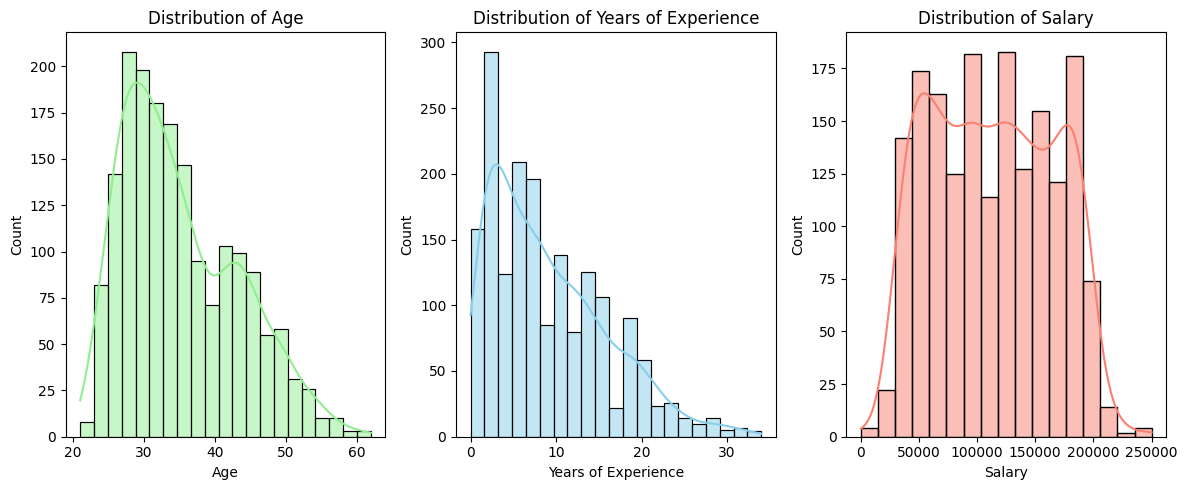

In [8]:
# Plotting the histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_clean["Age"],kde=True, color="lightgreen")
plt.title("Distribution of Age")

plt.subplot(1, 3, 2)
sns.histplot(df_clean["Years of Experience"], kde=True, color="skyblue")
plt.title("Distribution of Years of Experience")

plt.subplot(1, 3, 3)
sns.histplot(df_clean["Salary"], kde=True, color="salmon")
plt.title("Distribution of Salary")

plt.tight_layout()
plt.savefig("images/dataset_distributions.svg") 
plt.show()

In [9]:
# Data statistics
print("\nDataset statistics:")
df_clean.describe() 
# describe_extended_to_latex(df_clean, caption="Descriptive Statistics with Median and Mode")


Dataset statistics:


,Age,Years of Experience,Salary
count,1787.000000,1787.000000,1787.000000
mean,35.139899,9.156128,113184.659765
std,8.213045,6.844924,51596.536766
min,21.000000,0.000000,350.000000
25%,29.000000,3.000000,70000.000000
50%,33.000000,8.000000,110000.000000
75%,41.000000,13.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [10]:
# Top 10 salaries
print("\nTop 10 lowest salaries:")
print(df_clean["Salary"].sort_values(ascending=True).head(10))

# df_to_latex(
#     df_clean.sort_values(by="Salary", ascending=True).head(10),
#     num_rows=10,
#     caption="Top 10 Lowest Salaries"
# )



Top 10 lowest salaries:
248       350.0
1396      500.0
647       550.0
917       579.0
1433    25000.0
1456    25000.0
1473    25000.0
1452    25000.0
1324    25000.0
1317    25000.0
Name: Salary, dtype: float64


In [11]:
# Removing first 4 low salaries (outliers)
df_clean = df_clean[df_clean["Salary"] >= 24000].reset_index(drop=True)

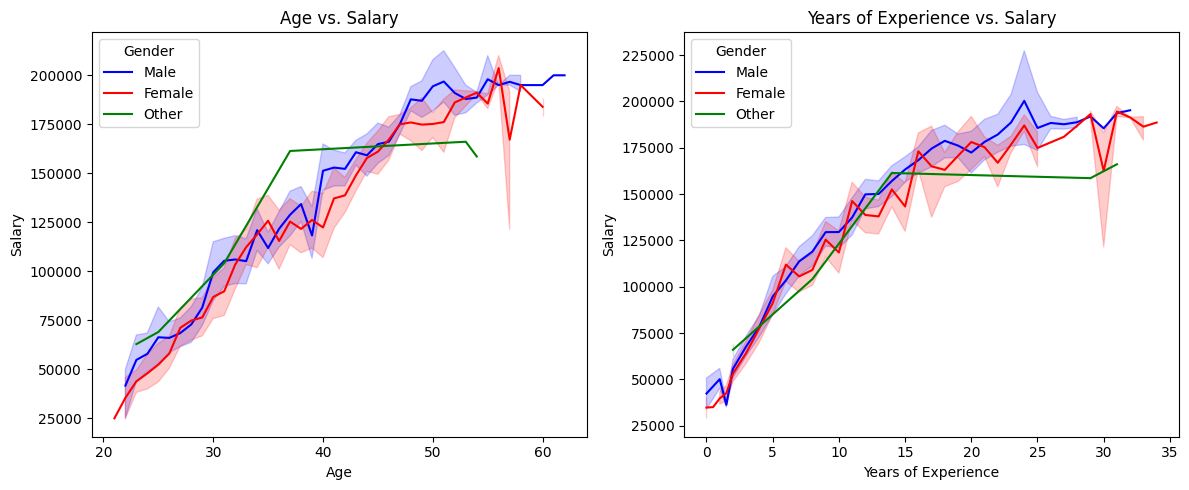

In [12]:
# Plotting age vs salary and years of experience vs salary
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_clean, x='Age', y='Salary', hue='Gender', palette={'Male': 'blue', 'Female': 'red', 'Other': 'green'})
plt.title("Age vs. Salary")

plt.subplot(1, 2, 2)
sns.lineplot(data=df_clean, x='Years of Experience', y='Salary', hue='Gender', palette={'Male': 'blue', 'Female': 'red', 'Other': 'green'})
plt.title("Years of Experience vs. Salary")

plt.tight_layout()
plt.savefig("images/age_and_yoe_vs_salary.svg") 
plt.show()


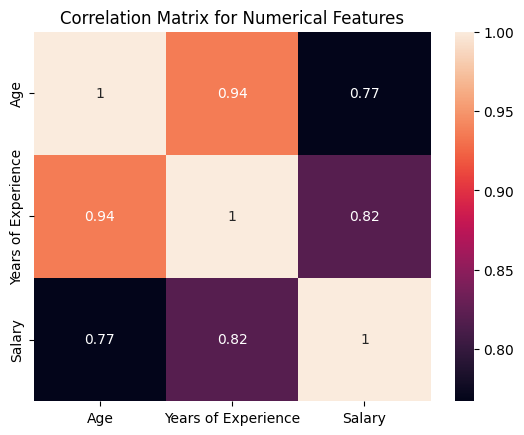

In [13]:
# Correlation matrix
sns.heatmap(df_clean.select_dtypes(include='number').corr(), annot=True)
plt.title("Correlation Matrix for Numerical Features")
plt.savefig("images/correlation_matrix.svg")
plt.show()

# Task 2: Feature Selection and Engineering

**2.1** Relevant Features

In [14]:
# Gender features count
gender_counts = df_clean["Gender"].value_counts()
gender_percentages = (gender_counts / len(df_clean)) * 100

gender_df = pd.DataFrame({
    "Count": gender_counts,
    "Percentage": gender_percentages.round(2)
})

print("\nGender features count:")
print(gender_df)


Gender features count:
        Count  Percentage
Gender                   
Male      964       54.07
Female    812       45.54
Other       7        0.39


In [15]:
# Removing 'Other' gender
df_clean = df_clean[df_clean["Gender"] != "Other"].reset_index(drop=True)
print("\nAfter removing 'Other' gender, unique values:", df_clean['Gender'].unique())


After removing 'Other' gender, unique values: ['Male' 'Female']


In [16]:
# Salary stats by gender
salary_by_gender = pd.DataFrame({
    gender: group['Salary'].reset_index(drop=True)
    for gender, group in df_clean.groupby('Gender')
})

salary_by_gender.describe()
# describe_extended_to_latex(salary_by_gender, caption="Salary stats by Gender")

,Female,Male
count,812.000000,964.000000
mean,107557.778325,118300.164938
std,50547.289889,51629.891895
min,25000.000000,25000.000000
25%,60750.000000,75000.000000
50%,105000.000000,120000.000000
75%,150000.000000,165000.000000
max,220000.000000,250000.000000


In [17]:
# Level of education features count
education_counts = df_clean["Education Level"].value_counts()
education_percentages = (education_counts / len(df_clean)) * 100

education_df = pd.DataFrame({
    "Count": education_counts,
    "Percentage": education_percentages.round(2)
})

print("\nLevel of education features count:")
print(education_df)


Level of education features count:
                   Count  Percentage
Education Level                     
Bachelor's Degree    504       28.38
Master's Degree      445       25.06
PhD                  339       19.09
Bachelor's           261       14.70
Master's             122        6.87
High School          104        5.86
phD                    1        0.06


In [18]:
# Merging Education Levels
mapping_education = {
    "phD": "PhD",
    "Bachelor's": "Bachelor's Degree",
    "Master's": "Master's Degree"
}

df_clean['Education Level'] = df_clean['Education Level'].replace(mapping_education)
print("\nAfter merging Education Level, unique values:", df_clean['Education Level'].unique())


After merging Education Level, unique values: ["Bachelor's Degree" "Master's Degree" 'PhD' 'High School']


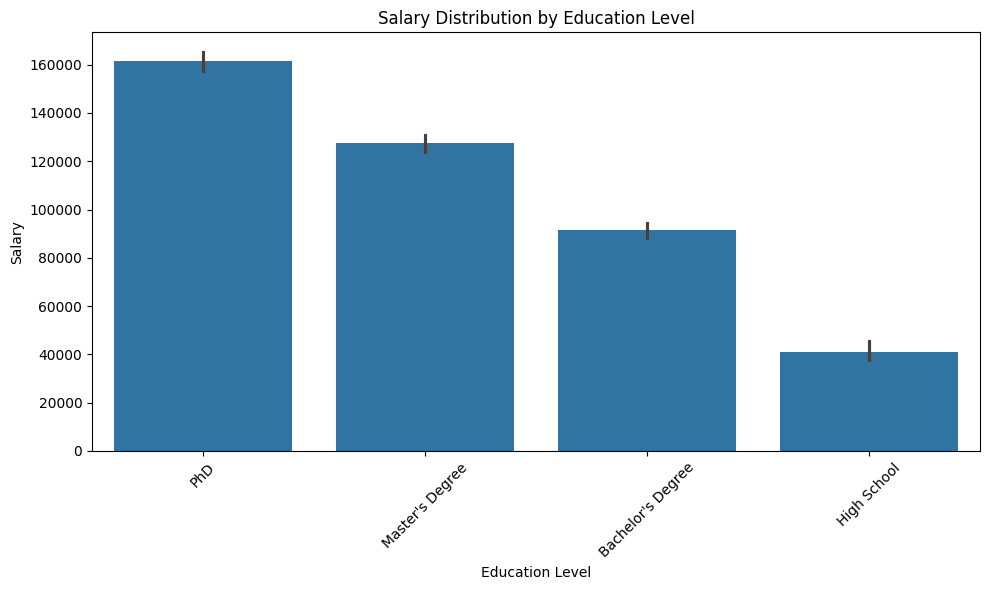

In [19]:
# Plotting salary vs education level (x_order : ['PhD', "Master's Degree", "Bachelor's Degree", "High School"])
plt.figure(figsize=(10, 6))

sns.barplot(data=df_clean, x='Education Level', y='Salary', order=['PhD', "Master's Degree", "Bachelor's Degree", "High School"])
plt.title('Salary Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/salary_vs_education.svg")
plt.show()

In [20]:
# Map the whole job title to lowercase
df_clean['Job Title'] = df_clean['Job Title'].str.lower()
print("\nUnique job titles (in lower case):", df_clean['Job Title'].str.lower().nunique())


Unique job titles (in lower case): 190


In [21]:
# Print the top 10 most repeated job titles
top_jobs = df_clean["Job Title"].value_counts().head(10).reset_index()
top_jobs.columns = ["Job Title", "Frequency"]

print(top_jobs)

# df_to_latex(top_jobs, num_rows=10, caption="Top 20 Most Frequent Job Titles")

                   Job Title  Frequency
0  software engineer manager        126
1        full stack engineer        120
2   senior software engineer         94
3    senior project engineer         94
4         back end developer         80
5             data scientist         80
6          software engineer         78
7        front end developer         73
8          marketing manager         55
9            product manager         53


/tmp/ipykernel_48877/1363725489.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20, x='Average Salary', y='Job Title', palette='viridis')


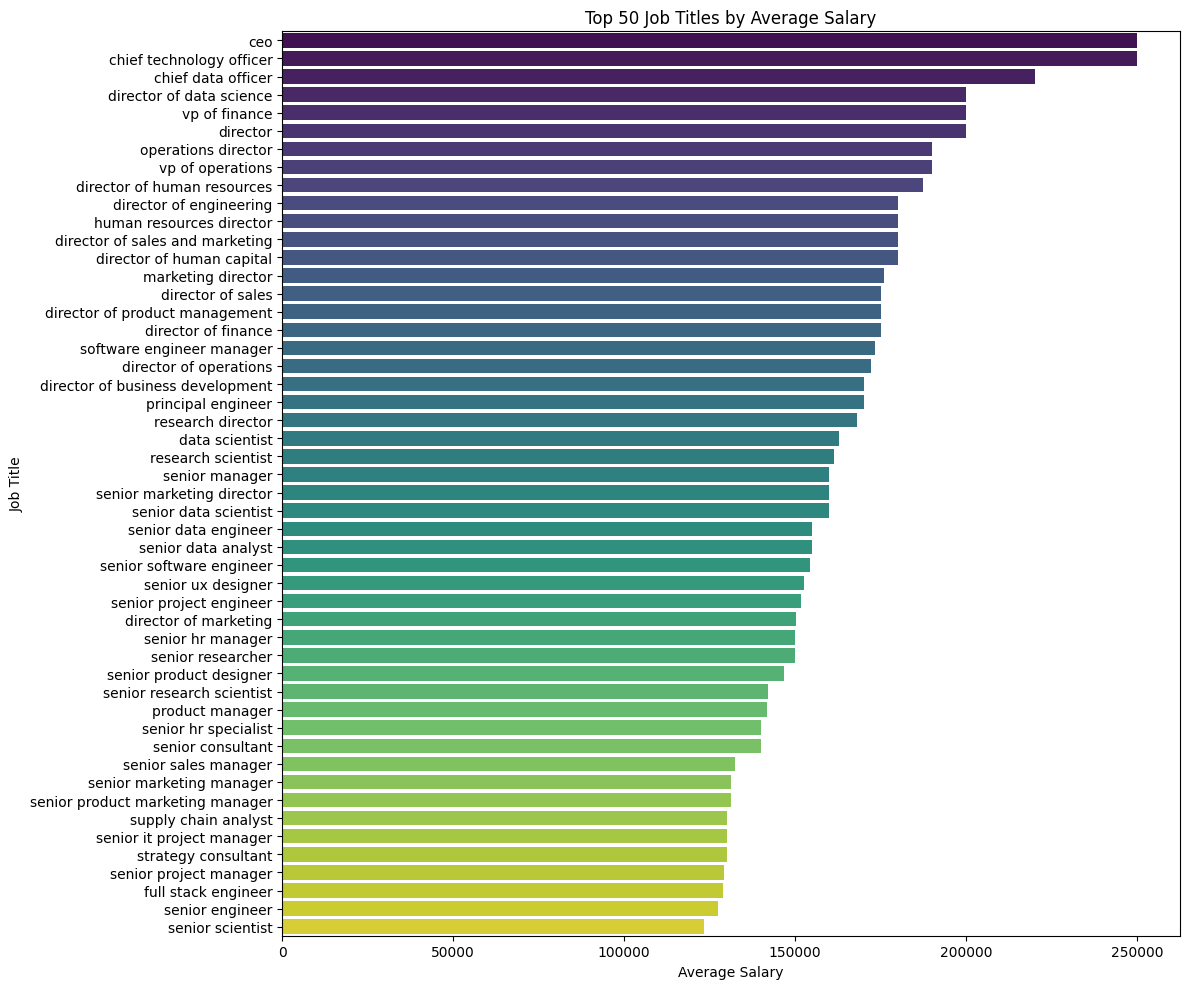

In [22]:
# Average salary by unique job title
top_20 = df_clean.groupby('Job Title')['Salary'].mean().reset_index(name='Average Salary').sort_values('Average Salary', ascending=False).head(50)

plt.figure(figsize = (12, 10))
sns.barplot(data=top_20, x='Average Salary', y='Job Title', palette='viridis')
plt.title('Top 50 Job Titles by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Job Title')
plt.tight_layout()
plt.savefig("images/top_50_job_titles_salary.svg")

plt.show()

In [23]:
# Count of Senior and Junior/Juniour in job titles 
print("Number of \"senior\" jobs:", df_clean["Job Title"].str.contains("senior").sum())
print("Number of \"junior\" jobs:", df_clean["Job Title"].str.contains("junior").sum())
print("Number of \"juniour\" jobs:", df_clean["Job Title"].str.contains("juniour").sum())

Number of "senior" jobs: 363
Number of "junior" jobs: 176
Number of "juniour" jobs: 4


In [24]:
# Remapping seniority into a new column
def add_seniority_column(df, col="Job Title"):
    def get_seniority(title):
        title_lower = title.lower()
        if "senior" in title_lower:
            return "Senior"
        elif "junior" in title_lower or "juniour" in title_lower:
            return "Junior"
        else:
            return "None"
    
    def clean_title(title):
        title = title.replace("senior", "").replace("junior", "").replace("juniour", "")
        return title.strip()

    df["Seniority"] = df[col].apply(get_seniority)
    df[col] = df[col].apply(clean_title)
    return df

df_clean = add_seniority_column(df_clean)
df_clean.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Seniority
0,32.0,Male,Bachelor's Degree,software engineer,5.0,90000.0,None
1,28.0,Female,Master's Degree,data analyst,3.0,65000.0,None
2,45.0,Male,PhD,manager,15.0,150000.0,Senior
3,36.0,Female,Bachelor's Degree,sales associate,7.0,60000.0,None
4,52.0,Male,Master's Degree,director,20.0,200000.0,None


In [25]:
# Remapping management positions into a new column (binary)
def add_management_column(df, col="Job Title"):
    def is_management(title):
        title = title.lower()
        return any(k in title for k in ["manager", "director", "executive", "chief", "ceo", "vp", "principal"])
    
    def clean_title(title):
        if len(title.split(" ")) > 1:
            title = title.replace("manager", "").replace("director", "").replace("executive", "").replace("chief", "").replace("ceo", "").replace("vp", "").replace("principal", "")
        return title.strip()

    df["Is Management"] = df[col].apply(is_management)
    df[col] = df[col].apply(clean_title)
    return df

df_clean = add_management_column(df_clean)
df_clean.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Seniority,Is Management
0,32.0,Male,Bachelor's Degree,software engineer,5.0,90000.0,None,False
1,28.0,Female,Master's Degree,data analyst,3.0,65000.0,None,False
2,45.0,Male,PhD,manager,15.0,150000.0,Senior,True
3,36.0,Female,Bachelor's Degree,sales associate,7.0,60000.0,None,False
4,52.0,Male,Master's Degree,director,20.0,200000.0,None,True


In [26]:
# Count how many in management positions
print("Number of management positions:", df_clean["Is Management"].sum())

Number of management positions: 615


In [27]:
# Check now number of unique job titles
print("\nUnique job titles (in lower case):", df_clean['Job Title'].str.lower().nunique())


Unique job titles (in lower case): 115


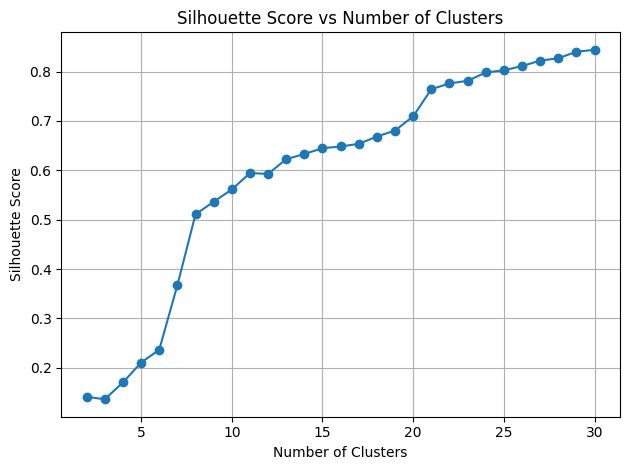

In [28]:
# Clustering job titles
job_titles = df_clean["Job Title"].str.lower().tolist()

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 1))
X = vectorizer.fit_transform(job_titles)

range_n_clusters = range(2, 31)
sil_scores = []

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X)
    
    sil_scores.append(silhouette_score(X, labels))

# Plot
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.savefig("images/silhouette_score.svg")
plt.tight_layout()
plt.show()


In [29]:
# Selecting the best number of clusters
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

job_cluster_map = dict(zip(job_titles, labels))

df_clean["Job Clustered"] = df_clean["Job Title"].str.lower().map(job_cluster_map)


# Print 3 unique jobs per each cluster:
for cluster_id in sorted(df_clean["Job Clustered"].unique()):
    print(f"\nCluster {cluster_id}:")
    titles = df_clean[df_clean["Job Clustered"] == cluster_id]["Job Title"].unique()
    for title in titles[:3]:
        print(f"  - {title}")

for cluster_id in sorted(df_clean["Job Clustered"].unique()):
    print(f"\\item \\textbf{{Cluster {cluster_id}}}")
    print("  \\begin{itemize}")
    titles = df_clean[df_clean["Job Clustered"] == cluster_id]["Job Title"].unique()
    for title in titles[:3]:
        print(f"    \\item {title}")
    print("  \\end{itemize}\n")



Cluster 0:
  - full stack engineer

Cluster 1:
  - marketing analyst
  - marketing coordinator
  - marketing

Cluster 2:
  - project
  - project engineer
  - project coordinator

Cluster 3:
  - sales associate
  - sales
  - sales representative

Cluster 4:
  - software engineer
  - engineer
  - software

Cluster 5:
  - manager
  - director
  - software developer

Cluster 6:
  - data analyst
  - scientist
  - data scientist

Cluster 7:
  - product
  - product designer
  - product marketing
\item \textbf{Cluster 0}
  \begin{itemize}
    \item full stack engineer
  \end{itemize}

\item \textbf{Cluster 1}
  \begin{itemize}
    \item marketing analyst
    \item marketing coordinator
    \item marketing
  \end{itemize}

\item \textbf{Cluster 2}
  \begin{itemize}
    \item project
    \item project engineer
    \item project coordinator
  \end{itemize}

\item \textbf{Cluster 3}
  \begin{itemize}
    \item sales associate
    \item sales
    \item sales representative
  \end{itemize}

\item \

In [30]:
# Print clusters distribution
for cluster_id in sorted(df_clean["Job Clustered"].unique()):
    print(f"Cluster {cluster_id}: {df_clean[df_clean['Job Clustered'] == cluster_id].shape[0]} individuals")

Cluster 0: 120 individuals
Cluster 1: 209 individuals
Cluster 2: 118 individuals
Cluster 3: 136 individuals
Cluster 4: 310 individuals
Cluster 5: 624 individuals
Cluster 6: 166 individuals
Cluster 7: 93 individuals


In [31]:
# Mapping categorical features into numbers
df_prediction = df_clean.copy()

mapping_gender = {"Male": 0, "Female": 1}
mapping_education = {"High School": 0, "Bachelor's Degree": 1, "Master's Degree": 2, "PhD": 3}
mapping_seniority = {"None": 0, "Junior": 1, "Senior": 2}
mapping_management = {False: 0, True: 1}

df_prediction["Gender"] = df_clean["Gender"].map(mapping_gender)
df_prediction["Education Level"] = df_clean["Education Level"].map(mapping_education)
df_prediction["Seniority"] = df_clean["Seniority"].map(mapping_seniority)
df_prediction["Is Management"] = df_clean["Is Management"].map(mapping_management)

df_prediction.drop("Job Title", axis=1, inplace=True)

salary = df_prediction.pop('Salary') 
df_prediction['Salary'] = salary 


df_prediction.head()
# df_to_latex(df_prediction, num_rows=5, caption="Final dataset")

,Age,Gender,Education Level,Years of Experience,Seniority,Is Management,Job Clustered,Salary
0,32.0,0,1,5.0,0,0,4,90000.0
1,28.0,1,2,3.0,0,0,6,65000.0
2,45.0,0,3,15.0,2,1,5,150000.0
3,36.0,1,1,7.0,0,0,3,60000.0
4,52.0,0,2,20.0,0,1,5,200000.0


# Task 3: Model Development and Evaluation

**3.1** Dataset split

In [32]:
# Splitting the dataset
features = ["Age", "Gender", "Education Level", "Years of Experience", "Seniority", "Is Management", "Job Clustered"]
target = "Salary"

X_train, X_test, y_train, y_test = train_test_split(df_prediction[features], df_prediction[target], test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1420, 7)
X_test shape: (356, 7)
y_train shape: (1420,)
y_test shape: (356,)


**3.2** Model selection


In [33]:
# Random Forest regressor model 
model = RandomForestRegressor(random_state=42)
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


**3.3** Model training

On the train set:
R² Score: 0.97
Root Mean Squared Error: 8089.99
Mean Absolute Error: 5119.92


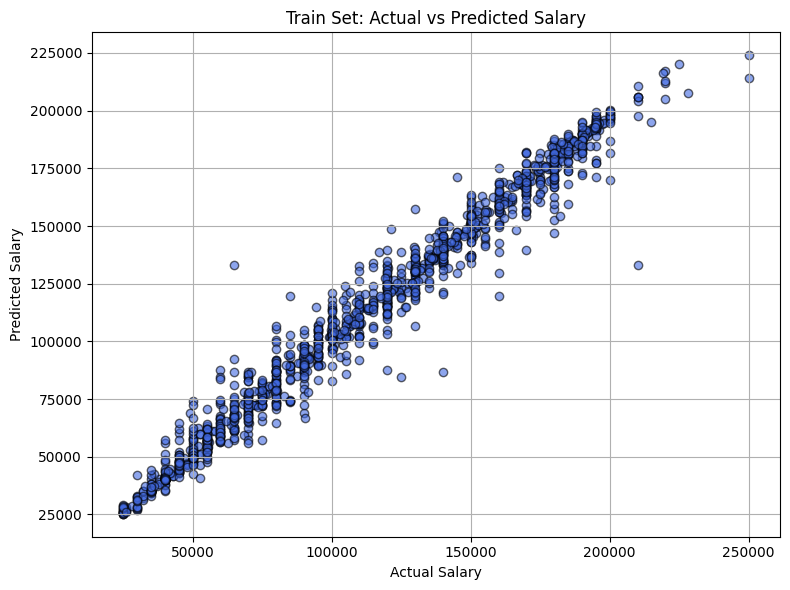

In [34]:
# Training the model
model.fit(X_train, y_train)

print("On the train set:")
y_pred_train = model.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = model.score(X_train, y_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print(f"R² Score: {r2_train:.2f}")
print(f"Root Mean Squared Error: {rmse_train:.2f}")
print(f"Mean Absolute Error: {mae_train:.2f}")


plt.figure(figsize=(8, 6))
plt.grid(True)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='royalblue', edgecolor='k')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Train Set: Actual vs Predicted Salary")
plt.tight_layout()
plt.savefig("images/train_pred.svg")
plt.show()

**3.4** Hyperparameters Fine Tuning

In [35]:
# Current model parameters 
print("Model params:\n", model.get_params())

Model params:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


# Task 4: Prediction and Interpretation

**4.1**: Making predictions on unseen data

In [36]:
# Evaluation of the model on the test set
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("On the test set:")
print(f"R² Score: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

On the test set:
R² Score: 0.89
Root Mean Squared Error: 17582.63
Mean Absolute Error: 11435.85


**4.2** Comparing real and predicted salaries 

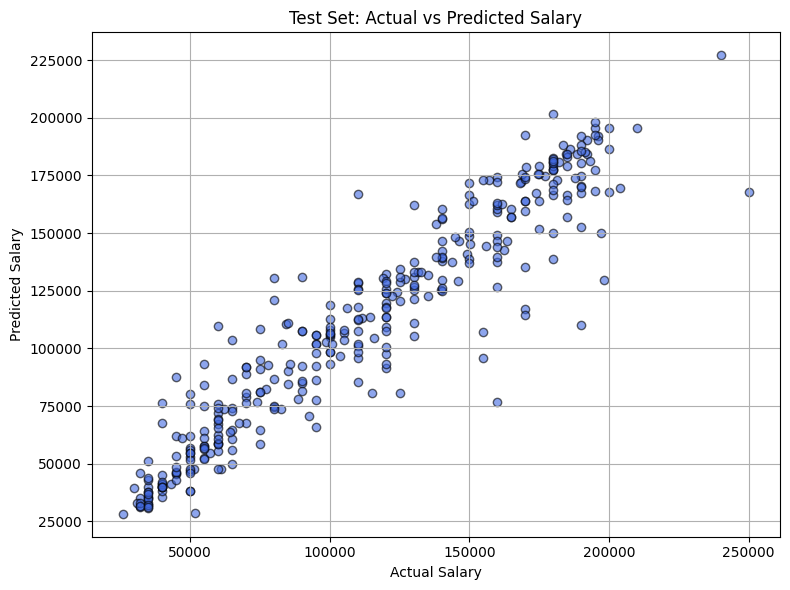

In [37]:
# Comparing actual and predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue', edgecolor='k')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Test Set: Actual vs Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.savefig("images/test_pred.svg")
plt.show()

**4.3** Interpreting the results

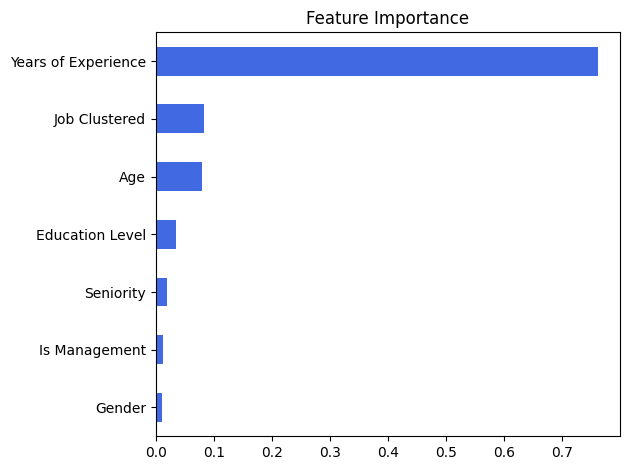

In [38]:
# Feature importance
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.sort_values().plot(kind='barh', color='royalblue')
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("images/feature_importances.svg")
plt.show()
